# JoinKeys
This notebook focuses on join keys. The file produces the files
1. df_sol: solliciation keys with jobseeker and vacancy join keys
2. df_jobseekers: joinkeys for jobseeker that match the ones in 1., but also filtered such that relevant side information is available from some relevan tables. Jobseekers need both ikl and klant_id to be able to join with all relevant side info.
3. df_vacancies: same as in 2., but for vacancies. Need bot ID and VAC_OPENING_ID to uniquely identify .

Note that in 1, there are more jobseekers and vacancies, there is a second notebook that filters 1 on several critera.

In [1]:
import sys

In [2]:
sys.version

'3.7.10 (default, Feb 26 2021, 18:47:35) \n[GCC 7.3.0]'

In [3]:
sys.version

'3.7.10 (default, Feb 26 2021, 18:47:35) \n[GCC 7.3.0]'

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pandas as pd
from pyspark.sql import functions as F
from pyspark import RDD
from pyspark import Row
from pyspark.sql.functions import lit
#from pyspark.sql.types import IntegerType
#from pyspark.sql.functions import udf
#import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

In [5]:
"""
The unique codes are:
[
!'NIET GESOLLICITEERD WG',
! 'SOL_AFGESLOTEN',
 'GEEN REACTIE WERKGEVER',
* 'GEBREK MOTIVATIE',
* 'GEBREK DIPLOMA',
! 'SOLLICITATIEPROCEDURE BEZIG',
! 'OPDRACHT_OPEN',
! 'GEEN SOLLICITATIEGESPREK',
! 'SOLLICITATIEGESPREK',
! 'NIET GESOLLICITEERD',
! 'NIET AANGEWORVEN',
! 'GESOLLICITEERD',
* 'GEBREK ANDERE',
! 'SOL_HEROPEND',
 'ANDERE',
 'AANPASSING_DEADLINE',
* 'GEBREK COMPETENTIES',
! 'OPDRACHT_AFGEWERKT',
! 'AANGEWORVEN',
! 'FEEDBACK SOLLICITATIEGESPREK',
* 'GEBREK ATTITUDES',
* 'GEBREK ERVARING']

* : VDAB: "Those infrequent options (e.g. a mediator who says the customer has a lack of experience) can be ignored, I think. That may not exist anymore."
! : These codes are used in the 'cleancodes'.

Without label */! :  not (yet) used.
"""

def cleancodes(r):
    IDv = r["SOLLICITATIEID"]
    CODESv = r["collect_set(CODE)"]
        
    #1. opdracht 
    OPDRACHTv = np.nan
    if 'OPDRACHT_OPEN' in CODESv:
        OPDRACHTv=1.0
    if 'OPDRACHT_AFGEWERKT' in CODESv:
        OPDRACHTv = 1.0

    #2. sollicitatie
    SOLLICITATIEv = np.nan
    if 'NIET GESOLLICITEERD' in CODESv:
        SOLLICITATIEv=-1.0
    if 'NIET GESOLLICITEERD WG' in CODESv:
        SOLLICITATIEv=-1.0
    if 'GESOLLICITEERD' in CODESv:
        SOLLICITATIEv=1.0
    if 'SOL_HEROPEND' in CODESv:
        SOLLICITATIEv = 1.0
    if 'SOLLICITATIEPROCEDURE BEZIG' in CODESv:
        SOLLICITATIEv = 1.0
    if 'SOL_AFGESLOTEN' in CODESv:
        SOLLICITATIEv = 1.0
        
    #3. interview
    INTERVIEWv = np.nan
    if 'GEEN SOLLICITATIEGESPREK' in CODESv:
        INTERVIEWv=-1.0
    if 'SOLLICITATIEGESPREK' in CODESv:
        INTERVIEWv=1.0
    if 'FEEDBACK SOLLICITATIEGESPREK' in CODESv:
        INTERVIEWv=1.0

        
    #4. hired
    HIREDv = np.nan
    if 'NIET AANGEWORVEN' in CODESv:
        HIREDv=-1.0
    if 'AANGEWORVEN' in CODESv:
        HIREDv=1.0

    return Row(ID = IDv, OPDRACHT=OPDRACHTv, SOLLICITATIE=SOLLICITATIEv, INTERVIEW=INTERVIEWv, HIRED=HIREDv)

In [6]:
"""
def cleancodes(r):
    IDv = r["SOLLICITATIEID"]
    CODESv = r["collect_set(CODE)"]
        
    #1. opdracht 
    OPDRACHTv = np.nan
    if 'OPDRACHT_OPEN' in CODESv:
        OPDRACHTv=1.0

    #2. sollicitatie
    SOLLICITATIEv = np.nan
    if 'NIET GESOLLICITEERD' in CODESv:
        SOLLICITATIEv=0
    if 'NIET GESOLLICITEERD WG' in CODESv:
        SOLLICITATIEv=0
    if 'GESOLLICITEERD' in CODESv:
        SOLLICITATIEv=1.0
        
    #3. interview
    INTERVIEWv = np.nan
    if 'GEEN SOLLICITATIEGESPREK' in CODESv:
        INTERVIEWv=0
    if 'SOLLICITATIEGESPREK' in CODESv:
        INTERVIEWv=1.0
    if 'FEEDBACK SOLLICITATIEGESPREK' in CODESv:
        INTERVIEWv=1.0

        
    #4. hired
    HIREDv = np.nan
    if 'NIET AANGEWORVEN' in CODESv:
        HIREDv=0
    if 'AANGEWORVEN' in CODESv:
        HIREDv=1.0

    return Row(ID = IDv, OPDRACHT=OPDRACHTv, SOLLICITATIE=SOLLICITATIEv, INTERVIEW=INTERVIEWv, HIRED=HIREDv)
"""

'\ndef cleancodes(r):\n    IDv = r["SOLLICITATIEID"]\n    CODESv = r["collect_set(CODE)"]\n        \n    #1. opdracht \n    OPDRACHTv = np.nan\n    if \'OPDRACHT_OPEN\' in CODESv:\n        OPDRACHTv=1.0\n\n    #2. sollicitatie\n    SOLLICITATIEv = np.nan\n    if \'NIET GESOLLICITEERD\' in CODESv:\n        SOLLICITATIEv=0\n    if \'NIET GESOLLICITEERD WG\' in CODESv:\n        SOLLICITATIEv=0\n    if \'GESOLLICITEERD\' in CODESv:\n        SOLLICITATIEv=1.0\n        \n    #3. interview\n    INTERVIEWv = np.nan\n    if \'GEEN SOLLICITATIEGESPREK\' in CODESv:\n        INTERVIEWv=0\n    if \'SOLLICITATIEGESPREK\' in CODESv:\n        INTERVIEWv=1.0\n    if \'FEEDBACK SOLLICITATIEGESPREK\' in CODESv:\n        INTERVIEWv=1.0\n\n        \n    #4. hired\n    HIREDv = np.nan\n    if \'NIET AANGEWORVEN\' in CODESv:\n        HIREDv=0\n    if \'AANGEWORVEN\' in CODESv:\n        HIREDv=1.0\n\n    return Row(ID = IDv, OPDRACHT=OPDRACHTv, SOLLICITATIE=SOLLICITATIEv, INTERVIEW=INTERVIEWv, HIRED=HIREDv)\n

In [7]:
def comparematch(a,b):
    inters = set(a).intersection(set(b))
    print(len(inters)/ len(a)  , len(inters)/ len(b))

In [8]:
def sollicitations_table():

    try: # if file already exists, no need to produce again
        df_sol = sqlContext.read.parquet(savedir+'df_sol')
    except:
    
        ### prepare the solliciations table

        # 1. this table contains identifiers, dates.
        sol = sqlContext.read.parquet(datadir+"/sollicitaties/")

        # 2. this table contains more information, such as the feedback codes 
        sol_activity = sqlContext.read.parquet(datadir+"/sollicitaties-activiteit/")
        # 2.1 the codes are grouped and aggregated per sollicitation. Then the codes are cleaned and structured as defined in 'def cleancodes(r)'
        sol_activity_codes_cleaned=sol_activity.select(["SOLLICITATIEID", "CODE"]).groupBy("SOLLICITATIEID").agg(F.collect_set("CODE")).rdd.map(cleancodes).toDF()

        # 3. join the tables from 1. and 2. to obtain a joined table with as columns ID jobseeker and vacancy and the relations. And also a date.
        df_sol = sol_activity_codes_cleaned.join(sol, ["ID"], how='inner').select(["ID","OPDRACHT","SOLLICITATIE","INTERVIEW","HIRED","WERKZOEKENDEID","VACATUREID", "DTM_CRE"])
        df_sol = df_sol.replace(float('nan'), None)
        
        # 4. it is possible that none of the codes is present (e.g. record originating from a code that is not usable): filter
        df_sol = df_sol.filter((df_sol['OPDRACHT']!=np.nan)|(df_sol['SOLLICITATIE']!=np.nan)|(df_sol['INTERVIEW']!=np.nan)
             |(df_sol['HIRED']!=np.nan))

        # 4. the dataframe is saved and reloaded.
        df_sol.write.parquet(savedir+'df_sol')
        df_sol = sqlContext.read.parquet(savedir+'df_sol')
    
    # 5. return df_sol, a unique list of jobseekerids and vacancy ids
    
    sol_jobseekers = list(df_sol.select(["WERKZOEKENDEID"]).distinct().toPandas()["WERKZOEKENDEID"])
    sol_vacancies = list(df_sol.select(["VACATUREID"]).distinct().toPandas()["VACATUREID"])
    return df_sol.fillna(np.nan), sol_jobseekers, sol_vacancies
    

In [9]:
def add_clicks(df_sol, jobseekers, vacancies):
    
    try:
        df_sol_withclicks = sqlContext.read.parquet(savedir+'df_sol_withclicks')
    except:

        # contains clicks linked with cookies:
        clicks = sqlContext.read.parquet(datadir+"/vacancy-clicks/")
        # links cookies to jobseekers
        cookieklantmatcher = sqlContext.read.parquet(datadir+"/cookie-klant-matcher/")

        # join the ikl key to the clicks via the cookieklantmatcher
        clickswithikl = cookieklantmatcher.join(clicks, \
                    cookieklantmatcher.username == clicks.username).select(['vacatureId','ikl','aantal_bekeken'])\
                    .withColumnRenamed('vacatureId', 'VAC_OPENING_ID')
        clickswithiklfilter_ = clickswithikl.groupBy(['ikl', 'VAC_OPENING_ID']).count().withColumnRenamed('count', 'CLICKS').withColumn('CLICKS_BINARY', lit(1))

        df_sol_withclicks = df_sol.join(clickswithiklfilter_.withColumnRenamed('ikl','WERKZOEKENDEID').withColumnRenamed('VAC_OPENING_ID','VACATUREID'),\
                    ['WERKZOEKENDEID', 'VACATUREID'], how='outer')

        df_sol_withclicks.write.parquet(savedir+'df_sol_withclicks')
        df_sol_withclicks = sqlContext.read.parquet(savedir+'df_sol_withclicks')
    
    return df_sol_withclicks.fillna(np.nan), jobseekers, vacancies

In [10]:
def conditional(df, condition, conditionv, var, varv):
    return df.filter((df[condition]==conditionv) & (df[var]==varv)).count() / df.filter(df[condition]==conditionv).count()
def conditionalmatrix(df, condition, conditionvs, var, varvs):
    res = np.zeros((len(varvs), len(conditionvs)))
    for i in range(len(varvs)):
        for j in range(len(conditionvs)):
            res[i,j] = conditional(df, condition, conditionvs[j], var, varvs[i])
    return res

In [11]:

def tomonotonechain_pos(df, condition, tochange):
    if condition is not None:
        return df\
        .withColumn(tochange+'_New',when(df[condition] == 1,1).otherwise(df[tochange]))\
        .drop(df[tochange])\
        .withColumnRenamed(tochange+'_New', tochange)
    else:
        return df\
        .withColumn(tochange+'_New', lit(1))\
        .drop(df[tochange])\
        .withColumnRenamed(tochange+'_New', tochange)
    
def tomonotonechain_neg(df, condition, tochange):
    return df\
    .withColumn(tochange+'_New',when(df[condition] == -1,-1).otherwise(df[tochange]))\
    .drop(df[tochange])\
    .withColumnRenamed(tochange+'_New', tochange)
    
def tomonotonechain_nan(df, condition, tochange):
    return df\
    .withColumn(tochange+'_New',when(df[condition] == np.nan,np.nan).otherwise(df[tochange]))\
    .drop(df[tochange])\
    .withColumnRenamed(tochange+'_New', tochange)
    
def make_monotone(df_test):
    # filter on clicks==1. It seems to be possible in a way to give feeback on a sollicitation without
    # clicking on it. (how is this possible on the website?) To be sure: filtered out.
    count_i = df_test.count()    
    df_test = df_test.filter(df_test['CLICKS_BINARY']==1)
    count_e = df_test.count()
    print("Sollicitations without clicks removed (proportion): ", (count_i-count_e)/count_i)

    
    # remove contradictories (and print how much: negligible)
    count_i = df_test.count()
    df_test = df_test.filter(~((df_test['SOLLICITATIE']==-1) &(df_test['INTERVIEW']==1)))
    df_test = df_test.filter(~((df_test['SOLLICITATIE']==-1) &(df_test['HIRED']==1)))
    df_test = df_test.filter(~((df_test['INTERVIEW']==-1) &(df_test['HIRED']==1)))
    count_e = df_test.count()
    print("Condradictory sollicitations removed (proportion): ", (count_i-count_e)/count_i)
    return df_test


def impute_monotone(df_test):

    df_test = tomonotonechain_pos(df_test, tochange='INTERVIEW', condition='HIRED')
    df_test = tomonotonechain_pos(df_test, tochange='SOLLICITATIE', condition='INTERVIEW')
    #df_test = tomonotonechain_pos(df_test, tochange='CLICKS_BINARY', condition=None) # not executed: make_monotone assures each chain starting with click

    df_test = tomonotonechain_neg(df_test, tochange='INTERVIEW', condition='SOLLICITATIE')
    df_test = tomonotonechain_neg(df_test, tochange='HIRED', condition='INTERVIEW')
    # this is not done for clicks: clicks are not explicitly negative
    
    return df_test

#def make_strict_monotone_impute(df_test):    
#    return df_test.fillna(-1, ['SOLLICITATIE','INTERVIEW', 'HIRED'])

def make_monotone_withoutnan(df_test):
    
    return df_test.filter((df_test['CLICKS_BINARY']!=np.nan) & (df_test['SOLLICITATIE']!=np.nan) &
                    (df_test['INTERVIEW']!=np.nan) & (df_test['HIRED']!=np.nan))

def make_monotone_(df_test):
    # filter on clicks==1. It seems to be possible in a way to give feeback on a sollicitation without
    # clicking on it. (how is this possible on the website?) To be sure: filtered out.
    #count_i = df_test.count()    
    #df_test = df_test.filter(df_test['CLICKS_BINARY']==1)
    #count_e = df_test.count()
    #print("Sollicitations without clicks removed (proportion): ", (count_i-count_e)/count_i)

    
    # first remove contradictories (and print)
    count_i = df_test.count()
    df_test = df_test.filter(~((df_test['SOLLICITATIE']==-1) &(df_test['INTERVIEW']==1)))
    df_test = df_test.filter(~((df_test['SOLLICITATIE']==-1) &(df_test['HIRED']==1)))
    df_test = df_test.filter(~((df_test['INTERVIEW']==-1) &(df_test['HIRED']==1)))
    count_e = df_test.count()
    print("Condradictory sollicitations removed (proportion): ", (count_i-count_e)/count_i)

    df_test = tomonotonechain_pos(df_test, tochange='INTERVIEW', condition='HIRED')
    df_test = tomonotonechain_pos(df_test, tochange='SOLLICITATIE', condition='INTERVIEW')
    #df_test = tomonotonechain_pos(df_test, tochange='CLICKS_BINARY', condition='SOLLICITATIE')

    df_test = tomonotonechain_neg(df_test, tochange='INTERVIEW', condition='SOLLICITATIE')
    df_test = tomonotonechain_neg(df_test, tochange='HIRED', condition='INTERVIEW')
    # this is not done for clicks: clicks are not explicitly negative
    
    return df_test

In [12]:
def conditionalmatrices(df):
    m1 = conditionalmatrix(df, 'CLICKS_BINARY', [1], 'SOLLICITATIE', [1,-1])
    m2 = conditionalmatrix(df, 'SOLLICITATIE', [1,-1], 'INTERVIEW', [1,-1])
    m3 = conditionalmatrix(df, 'INTERVIEW', [1,-1], 'HIRED', [1,-1])
    m4 = conditionalmatrix(df, 'CLICKS_BINARY', [1], 'HIRED', [1,-1])

    return m1,m2,m3,m4

def conditionalmatrices_withnan(df):
    m1 = conditionalmatrix(df, 'CLICKS_BINARY', [1], 'SOLLICITATIE', [1,np.nan,-1])
    m2 = conditionalmatrix(df, 'SOLLICITATIE', [1,np.nan,-1], 'INTERVIEW', [1,np.nan,-1])
    m3 = conditionalmatrix(df, 'INTERVIEW', [1,np.nan,-1], 'HIRED', [1,np.nan,-1])
    m4 = conditionalmatrix(df, 'CLICKS_BINARY', [1], 'HIRED', [1,np.nan,-1])

    return m1,m2,m3,m4
    

In [13]:
def printproperties(df, withnan):
    printtrajectories(df)
    print('------------------------------------------')
    printm(df, withnan)
    print('------------------------------------------')
    printc(df)
    print('------------------------------------------')
    printproportions(df)

def printproportions(df):
    n = df.count()
    u = df.groupby('WERKZOEKENDEID').count()
    v = df.groupby('VACATUREID').count()
    print(n, u.count(), v.count())
    print(n / (u.count() * v.count())*100)
    a = u.toPandas()["count"]
    b = v.toPandas()["count"]

    plt.figure()
    plt.title('sollicitations per jobseeker')
    plt.hist(a, bins=20)
    plt.yscale("log")
    plt.figure()
    plt.title('sollicitions per vacancy')
    plt.hist(b, bins=20)
    plt.yscale("log")
    plt.show()
    
def printtrajectories(df):
    print(df.select(["CLICKS_BINARY","SOLLICITATIE","INTERVIEW","HIRED"]).distinct().orderBy(["CLICKS_BINARY",'SOLLICITATIE','INTERVIEW']).toPandas())
def printm(df, withnan):
    if withnan:
        m = conditionalmatrices_withnan(df)
    else:
        m = conditionalmatrices(df)
        
    
    print('click to sol: ')
    print(m[0])
    print()
    
    print('sol to interview: ')
    print(m[1])
    print()
    
    print('interview to hired: ')
    print(m[2])
    print()
    
    print('click to sol to interview to hired')
    print(np.matmul(m[2], np.matmul(m[1],m[0])))
    print()
    
    print('click to hired')
    print(m[3])

def printc(df):
    print(df.groupby('CLICKS_BINARY').count().toPandas())
    print(df.groupby('SOLLICITATIE').count().toPandas())
    print(df.groupby('INTERVIEW').count().toPandas())
    print(df.groupby('HIRED').count().toPandas())


    

In [14]:
# main reason to do this: some users have exceptional number of applications even up to 6000. Errors? Automated scrapers?
def filter_on_number_of_interactions(df, 
                                     sol_per_jobseeker_min= 2, sol_per_jobseeker_max=100,
                                     sol_per_vacancy_min = 2,  sol_per_vacany_max = 50):
    n = df.count()
    u = df.groupby('WERKZOEKENDEID').count().withColumnRenamed('count', 'count_WERKZOEKENDEID')
    v = df.groupby('VACATUREID').count().withColumnRenamed('count', 'count_VACATUREID')
    
    df = df.join(u, on='WERKZOEKENDEID', how='left').join(v, on='VACATUREID', how='left')
    
    return df[(df['count_WERKZOEKENDEID']>=sol_per_jobseeker_min) & 
              (df['count_WERKZOEKENDEID']<=sol_per_jobseeker_max) &
              (df['count_VACATUREID']>=sol_per_vacancy_min) &
              (df['count_VACATUREID']<=sol_per_vacany_max)
             ]

In [15]:
spark = SparkSession.builder.master('local').appName('myAppName').config('spark.executor.memory', '150gb').config('spark.cores.max', "30").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [16]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
#np.set_printoptions()

In [17]:
# where the vdab data sets are stored
datadir = "/data/nextcloud/vdab_datasets_new/"

# where processed data sets are saved:
savedir = datadir + '/processed3/'

# 1. Create and save dataframe with jobseeker-vacancy interactions

'df_monotone' and 'df_monotone_strict_filter' are saved.

In [18]:
# From the solliciations, clean the data into specific relations. 
# Also, ad clicks to those jobseekers and vacancies that were present in the solliciations
df_sol, jobseekers, vacancies = sollicitations_table()
df_sol_withclicks, jobseekers, vacancies = add_clicks(df_sol, jobseekers, vacancies)

In [129]:
savecols = ['DTM_CRE','WERKZOEKENDEID','VACATUREID','CLICKS_BINARY', 'SOLLICITATIE', 'INTERVIEW', 'HIRED']

In [42]:
# create versions of monotone datasets. Make save them, and load them explicit again.

df_sol_withclicks_monotone = make_monotone(df_sol_withclicks.filter(df_sol_withclicks['OPDRACHT']==np.nan))
df_sol_withclicks_monotone.select(savecols).write.parquet(savedir+'df_sol_withclicks_monotone')
df_sol_withclicks_monotone = sqlContext.read.parquet(savedir+'df_sol_withclicks_monotone')

Sollicitations without clicks removed (proportion):  0.2608054634853686
Condradictory sollicitations removed (proportion):  1.4744018079887957e-05


In [43]:
df_sol_withclicks_monotone = sqlContext.read.parquet(savedir+'df_sol_withclicks_monotone')

In [46]:
# !! important to do this filtering first. There are seekers with incredible number of sollicitations.
# If they are not filtered first, they can contiminate after other filtering processes.

df_sol_withclicks_monotone_ = filter_on_number_of_interactions(df_sol_withclicks_monotone, 
                                     sol_per_jobseeker_min= 0, sol_per_jobseeker_max=100,
                                     sol_per_vacancy_min = 0,  sol_per_vacany_max = 50)
df_sol_withclicks_monotone_.select(savecols).write.parquet(savedir+'df_sol_withclicks_monotone_')
df_sol_withclicks_monotone_ = sqlContext.read.parquet(savedir+'df_sol_withclicks_monotone_')

In [47]:
df_sol_withclicks_monotone_ = sqlContext.read.parquet(savedir+'df_sol_withclicks_monotone_')

In [49]:
df_sol_withclicks_monotone_imputed = impute_monotone(df_sol_withclicks_monotone_)
df_sol_withclicks_monotone_imputed.select(savecols).write.parquet(savedir+'df_sol_withclicks_monotone_imputed')
df_sol_withclicks_monotone_imputed = sqlContext.read.parquet(savedir+'df_sol_withclicks_monotone_imputed')

In [50]:
df_sol_withclicks_monotone_imputed = sqlContext.read.parquet(savedir+'df_sol_withclicks_monotone_imputed')

In [51]:
df_sol_withclicks_monotone_imputed.select('CLICKS_BINARY').distinct().show()

+-------------+
|CLICKS_BINARY|
+-------------+
|            1|
+-------------+



In [52]:
jobseeker_sel = df_sol_withclicks_monotone_imputed.filter(df_sol_withclicks_monotone_imputed['HIRED']!=np.nan).select('WERKZOEKENDEID').distinct()
vacancy_sel = df_sol_withclicks_monotone_imputed.filter(df_sol_withclicks_monotone_imputed['HIRED']!=np.nan).select('VACATUREID').distinct()
df_sol_withclicks_sel = df_sol_withclicks_monotone_.join(jobseeker_sel, on='WERKZOEKENDEID', how='inner').join(vacancy_sel, on='VACATUREID', how='inner')
df_sol_withclicks_sel.select(savecols).write.parquet(savedir+'df_sol_withclicks_sel')
df_sol_withclicks_sel = sqlContext.read.parquet(savedir+'df_sol_withclicks_sel')

    CLICKS_BINARY  SOLLICITATIE  INTERVIEW  HIRED
0               1          -1.0       -1.0    NaN
1               1          -1.0        NaN    NaN
2               1          -1.0        NaN   -1.0
3               1           1.0       -1.0    NaN
4               1           1.0       -1.0   -1.0
5               1           1.0        1.0   -1.0
6               1           1.0        1.0    NaN
7               1           1.0        1.0    1.0
8               1           1.0        NaN    1.0
9               1           1.0        NaN    NaN
10              1           1.0        NaN   -1.0
11              1           NaN       -1.0   -1.0
12              1           NaN       -1.0    NaN
13              1           NaN        1.0   -1.0
14              1           NaN        1.0    NaN
15              1           NaN        1.0    1.0
16              1           NaN        NaN    NaN
17              1           NaN        NaN   -1.0
18              1           NaN        NaN    1.0


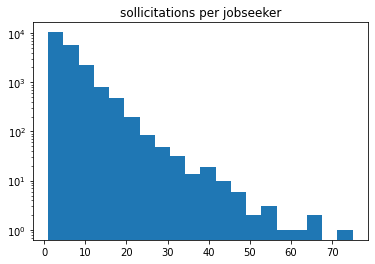

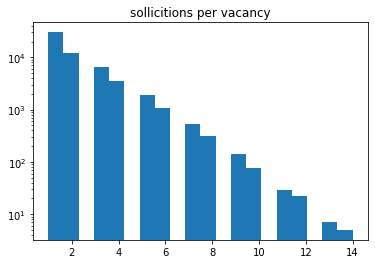

In [53]:
printproperties(df_sol_withclicks_sel, withnan=True)

# Compute sidefeatures

In [142]:
def plotextraproperties(df):
    df_pd = df.toPandas()
    plt.figure()
    pd.to_datetime(df_pd['DTM_CRE']).hist()
    plt.title('sollicitations per date')
    print(len(np.unique(df_pd.WERKZOEKENDEID)), len(np.unique(df_pd.VACATUREID)), len(df_pd))

In [143]:
def fx(x, uniquelistofcodes,code,score):
    res = pd.Series(data=np.zeros(len(uniquelistofcodes)), index=uniquelistofcodes)
    codes = list(x[code])
    if score is not None:
        scores = list(x[score])
        for i in range(len(codes)):
            res[codes[i]]=scores[i]
    else:
        for i in range(len(codes)):
            res[codes[i]]=1
        
    return res

In [144]:
# df: the jobseekers with klant_id and WERKZOEKENDEID (ikl) as jobseeker identifiers
# file: the file of the side information
# column: the column of the file needed to identify the jobseeker
# columnname: the columnname to merge on with df, if column is renamed in to columnname in order to merge with df
# code: column with a code wich is an identifier of a competence, studie, etc
# score: column in which codes are scored. If None (e.g. code is a certain study, but no score how good you are in the study), than a 1 value is assigned (binary).

def sidefeatures(df, file = datadir+"/gescoorde_competenties_historiek/",
                 column = 'X_IKL_SRC_ID', columnname = 'WERKZOEKENDEID', code = 'CODE', score = 'SCORE'):

    features = sqlContext.read.parquet(file).distinct().withColumnRenamed(column, columnname).filter(F.col(columnname).isin(list(df[columnname]))).toPandas()
    if type(code)==tuple and len(code)==2: #in case two codes are needed to uniquely define a competence.
        features['new_unique_code'] = features[code[0]]+features[code[1]]
        code = 'new_unique_code'
    
    features = features.dropna(subset=[code]) #code=None must be filtered out
    
    uniquelistofcodes = np.unique(features[code])
    features = features.groupby(columnname).apply(fx,uniquelistofcodes,code,score)
    return features

In [137]:
df_sol_withclicks_sel = sqlContext.read.parquet(savedir+'df_sol_withclicks_sel')
df_sol_withclicks_sel_pd = df_sol_withclicks_sel_.toPandas()
df_sol_withclicks_sel_pd = df_sol_withclicks_sel_pd[df_sol_withclicks_sel_pd.DTM_CRE.notnull()]
df_sol_withclicks_sel_pd[pd.to_datetime(df_sol_withclicks_sel_pd.DTM_CRE) > pd.to_datetime("01/01/2018T00:00:00")]
df_sol_withclicks_sel_pd[df_sol_withclicks_sel_pd.DTM_CRE!=None]

In [ ]:
# dataset for which we want to compute side features, and filter such that side features are available

dfstring = savedir+'df_sol_withclicks_sel'
dataset = sqlContext.read.parquet(dfstring)
print(dataset.count())
dataset.show(5)

In [ ]:
import matplotlib.pyplot as plt
plotextraproperties(dataset)

In [146]:
# 1. side info  of the job seekers
# 1.1 original identifiers. For side information of jobseekers, we need the table klant because it has both ikl and klant_id for joining side info
klant = sqlContext.read.parquet(datadir+"/klant_v5/").select(['ikl','klant_id']).distinct().withColumnRenamed('ikl', 'WERKZOEKENDEID')
klant = klant.join(dataset, on='WERKZOEKENDEID', how='inner').select(['WERKZOEKENDEID','klant_id']).toPandas().drop_duplicates()

# 1.2 gather the features of the jobseeker
gescoordecompetenties = sidefeatures(df = klant, file = datadir+"/gescoorde_competenties_historiek/",
                 column = 'X_IKL_SRC_ID', columnname = 'WERKZOEKENDEID', code = 'CODE', score = 'SCORE')
studies = sidefeatures(df = klant, file = datadir+"/wz-studies/",
                 column = 'klant_id', columnname = 'klant_id', code = 'studie_code', score = None)
talenkennis = sidefeatures(df = klant, file = datadir+"/wz-talenkennis/",
                 column = 'klant_id', columnname = 'klant_id', code = 'taal_code', score = 'evaluatie_algemeen')
beroepen = sidefeatures(df = klant, file = datadir+"/wz-beroepen/",
                 column = 'klant_id', columnname = 'klant_id', code = 'sjablooncode', score = 'ervaring')

# 1.3 merge al features to the jobseeker
klant_features = klant.merge(gescoordecompetenties, on='WERKZOEKENDEID',how='inner') \
    .merge(studies, on='klant_id', how='inner')\
    .merge(talenkennis, on='klant_id', how='inner')\
    .merge(beroepen, on='klant_id', how='inner')


# 2. side info of the vacancies
# 2.1 original identifiers
vacancy = dataset.select('VACATUREID').distinct().toPandas().drop_duplicates()

# 2.2 gather the features afthe vacancy
vaccompetenties = sidefeatures(df = vacancy, file = datadir+"vac_opening_competenties",
                 column = 'VAC_OPENING_ID', columnname = 'VACATUREID', code = ('COMP_SOORT','COMP_CODE'), score = None)
vaccompetentiezoeker = sidefeatures(df = vacancy, file = datadir+"vac_opening_competenties_competentiezoeker_comp1",
                 column = 'VAC_OPENING_ID', columnname = 'VACATUREID', code = 'ACTIVITEIT_ID', score = None)
vacdwh = sidefeatures(df = vacancy, file = datadir+"vac_opening_competenties_dwh_comp1",
                 column = 'VAC_OPENING_ID', columnname = 'VACATUREID', code = 'ACTIVITEIT_ID', score = None)

# 2.3 merge all features to the vacancy.
vacancy_features = vacancy.merge(vaccompetenties, on='VACATUREID',how='inner') \
    .merge(vaccompetentiezoeker, on='VACATUREID', how='inner')\
    .merge(vacdwh, on='VACATUREID', how='inner')

In [147]:
# 3. Merge datasets, filter, and add unique indices linking side info to links. Datasets are saved.

# filter dataframe and side features such that they have same set of jobseekers and vacancies
# (avoid large inner join, for memory reasons)


dataset_filtered= dataset\
    .filter(F.col('VACATUREID').isin(list(vacancy_features['VACATUREID'])))\
    .filter(F.col('WERKZOEKENDEID').isin(list(klant_features['WERKZOEKENDEID'])))

klant_features = klant_features\
        .merge(dataset_filtered.select('WERKZOEKENDEID').distinct().toPandas(), on='WERKZOEKENDEID',how='inner')
klant_features.insert(2, 'jobseeker_index', klant_features.index)

vacancy_features = vacancy_features\
        .merge(dataset_filtered.select('VACATUREID').distinct().toPandas(), on='VACATUREID',how='inner')
vacancy_features.insert(1, 'vacancy_index', vacancy_features.index)

dataset_filtered = dataset_filtered\
    .join(spark.createDataFrame(vacancy_features[['VACATUREID','vacancy_index']]),on='VACATUREID',how='inner')\
    .join(spark.createDataFrame(klant_features[['WERKZOEKENDEID','jobseeker_index']]),on='WERKZOEKENDEID',how='inner')\
    .select(['jobseeker_index','vacancy_index', 'CLICKS_BINARY', 'SOLLICITATIE', 'INTERVIEW','HIRED'])

In [148]:
dfstring

'/data/nextcloud/vdab_datasets_new//processed3/df_sol_withclicks_sel_2018'

In [149]:
dataset_filtered.show(5)

+---------------+-------------+-------------+------------+---------+-----+
|jobseeker_index|vacancy_index|CLICKS_BINARY|SOLLICITATIE|INTERVIEW|HIRED|
+---------------+-------------+-------------+------------+---------+-----+
|           1012|          733|            1|         NaN|      NaN| -1.0|
|           1012|          853|            1|         NaN|      NaN| -1.0|
|            931|          141|            1|         1.0|      NaN| -1.0|
|            931|          179|            1|         1.0|      1.0| -1.0|
|            931|          447|            1|        -1.0|      NaN|  NaN|
+---------------+-------------+-------------+------------+---------+-----+
only showing top 5 rows



In [150]:
# Data sets are saved here
#.write.parquet(dfstring+'withsideinfo')
dataset_filtered.toPandas().to_csv(dfstring+'withsideinfo', index=False)
klant_features.to_csv(dfstring+'sideinfojobseeker', index=False)
vacancy_features.to_csv(dfstring+'sideinfovacany', index=False)

# From here, data can be loaded and features transformed

In [ ]:
dfstring = savedir+'df_sol_withclicks_sel'


dataset_filtered = pd.read_csv(dfstring+'withsideinfo')
klant_features = pd.read_csv(dfstring+'sideinfojobseeker')
vacancy_features = pd.read_csv(dfstring+'sideinfovacany')

In [19]:
len(dataset_filtered)/len(klant_features)/len(vacancy_features)*100

0.01123456349891709

In [20]:
vacancy_features

,VACATUREID,vacancy_index,ATTEST10056,ATTEST10164,ATTEST10165,ATTEST10207,ATTEST10208,ATTEST10209,ATTEST10211,ATTEST10212,...,9894_y,9905_y,9916_y,992_y,9927_y,9938_y,9954_y,9964_y,9975_y,9986_y
0,52920645,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,53924036,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,54384651,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54548195,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,54597758,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42572,61055135,42572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42573,61091842,42573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42574,61115500,42574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42575,61117021,42575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
klant_features

,WERKZOEKENDEID,klant_id,jobseeker_index,10008,10019,1003,10030,10041,10052,10068,...,N410501-2,N420101-1,N420201-1,N420301-1,N420401-1,N430101-1,N430201-1,N440101-1,N440201-1,N440301-1
0,753add10e6035eeec760d7e9c300508faca384e0537dfe...,23fcee1aa7f6026845c06601cb0c111ccab916767fa074...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8ec897a30aadb40f2252359c4f1a2fd03406534fb4941b...,78661e303c03bad50c1042854523b02ac84ed55c380d7d...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,a434740da8b65e9f06c783b0750b92c6c7b8f0ee809ead...,f49ff71236a606388af4ddda7a2ffa4171cd432d3247a5...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,427f648c6d3ad9742f35640b72d9c3d806e91ac900daac...,dc12f5080f323249005d99f986d846fe27ffe75e549db4...,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1019ec5062da5b325fa96f97d2a0b86b8513b7db0a34d1...,0a0541b7b0d2381617d5918ad1cbd34284dedd1461da54...,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17234,d9eed70e1eba98114b845e9a5204a3b9425139a9363102...,cba41d6d6a2368e0105a7e4db87440c099523c07ccfe8a...,17234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17235,588ad22e924aa7a0b632431250b39a4b07ee939b6eab4b...,6ed38a7feabf568c20101a1ca6b467ef61c04997a0aa26...,17235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17236,59ff8000b7cd212ae735b029bec77dc1baaab139b73d7a...,c4e381013d1e7e95c4599ce0d847abf8b141ea31400451...,17236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17237,a444cc36fae89640bcd81079d03cb8e05577af3c216919...,b9950a7886b4b7565c80a325b18e1aaea84f9342dc4d89...,17237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
dataset_filtered

,jobseeker_index,vacancy_index,CLICKS_BINARY,SOLLICITATIE,INTERVIEW,HIRED
0,13606,7541,1,NaN,NaN,NaN
1,13606,13738,1,NaN,NaN,1.0
2,13606,15849,1,NaN,NaN,NaN
3,13606,22264,1,NaN,NaN,NaN
4,9468,2877,1,NaN,NaN,-1.0
...,...,...,...,...,...,...
82455,9357,33486,1,1.0,NaN,-1.0
82456,9357,37213,1,NaN,1.0,-1.0
82457,9357,41673,1,NaN,NaN,NaN
82458,9357,42349,1,NaN,NaN,NaN


    CLICKS_BINARY  SOLLICITATIE  INTERVIEW  HIRED
0               1          -1.0       -1.0    NaN
1               1          -1.0        NaN   -1.0
2               1          -1.0        NaN    NaN
3               1           1.0       -1.0    NaN
4               1           1.0       -1.0   -1.0
5               1           1.0        1.0    1.0
6               1           1.0        1.0   -1.0
7               1           1.0        1.0    NaN
8               1           1.0        NaN   -1.0
9               1           1.0        NaN    NaN
10              1           1.0        NaN    1.0
11              1           NaN       -1.0   -1.0
12              1           NaN       -1.0    NaN
13              1           NaN        1.0    1.0
14              1           NaN        1.0   -1.0
15              1           NaN        1.0    NaN
16              1           NaN        NaN    NaN
17              1           NaN        NaN   -1.0
18              1           NaN        NaN    1.0


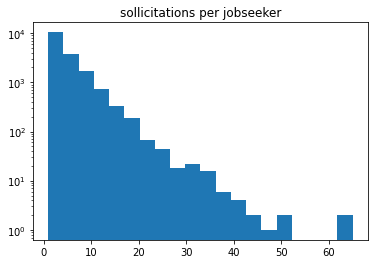

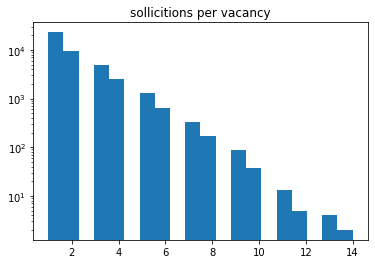

In [23]:
printproperties(spark.createDataFrame(dataset_filtered).withColumnRenamed('jobseeker_index','WERKZOEKENDEID').withColumnRenamed('vacancy_index','VACATUREID'), withnan=True)

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import scipy.linalg

In [26]:
Xjobseeker = np.array(klant_features)[:,3:].astype(float)
Xvacancy = np.array(vacancy_features)[:,2:].astype(float)

In [27]:
Kjobseeker = cosine_similarity(Xjobseeker)
Kvacancy = cosine_similarity(Xvacancy)

In [28]:
pcajobseeker = PCA(n_components = 15, svd_solver = 'randomized')
PCAjobseeker = pcajobseeker.fit_transform(Kjobseeker)

In [29]:
pcavacancy = PCA(n_components = 15, svd_solver = 'randomized')
PCAvacancy = pcavacancy.fit_transform(Kvacancy)

In [ ]:
np.savetxt(dfstring+'_Xjobseeker_PCA15', PCAjobseeker)
np.savetxt(dfstring+'_Xvacancy_PCA15', PCAvacancy)

# Final processings

In [18]:
processeddatadir = '/data/nextcloud/vdab_datasets_new/processed3/'


df = pd.read_csv(processeddatadir+"df_sol_withclicks_selwithsideinfo").replace(-1,0)
Xj = np.loadtxt(processeddatadir+"df_sol_withclicks_sel_Xjobseeker_PCA15")#[:,:20]
Xv = np.loadtxt(processeddatadir+"df_sol_withclicks_sel_Xvacancy_PCA15")#[:,:20]

Xj = np.append(Xj, np.array(len(Xj)*[np.sqrt(np.max(np.mean(Xj**2, axis=0)))]).reshape(-1,1), axis=1)
Xv = np.append(Xv, np.array(len(Xv)*[np.sqrt(np.max(np.mean(Xv**2, axis=0)))]).reshape(-1,1), axis=1)


assert len(np.unique(df.jobseeker_index))==len(Xj)
assert len(np.unique(df.vacancy_index))==len(Xv)
print(len(Xj), len(Xv))

print(Xj.shape, Xv.shape)
print(len(df)/len(Xj)/len(Xv))
print(len(df))

17239 42577
(17239, 16) (42577, 16)
0.00011234563498917089
82460


In [22]:
import copy
def impute_monotone2(df, fillna=False):
    # make sure to impute monotone
    res = copy.deepcopy(df)
    res.loc[res.HIRED == 1, 'INTERVIEW'] = 1
    res.loc[res.INTERVIEW == 1, 'SOLLICITATIE'] = 1
    
    res.loc[res.SOLLICITATIE == 0, 'INTERVIEW'] = 0
    res.loc[res.INTERVIEW == 0, 'HIRED'] = 0

    if fillna:
        #if they filled in solliciatie: but after that nothing: assume zero
        res.loc[(res.SOLLICITATIE == 1) & (np.isnan(res.INTERVIEW)), 'INTERVIEW'] = 0
        res.loc[(res.SOLLICITATIE == 1) & (np.isnan(res.HIRED)), 'HIRED'] = 0

    return res
df = impute_monotone2(df, fillna=True)

In [29]:
df.to_csv("VDAB_monotone_labels", index=False)
np.savetxt("VDAB_features_jobseekers", Xj)
np.savetxt("VDAB_features_vacancies", Xv)